# Calculate Insertion Coordinates

**Purpose:** Given a set of probes each moving along a unique set of local axes, how do we align them with targets in a global coordinate space?

**Prerequisites:** 
1. A calibration file (`calibration_info.py`) with the measured global and local coordinates at each calibration point
2. A set of targets (in global coordinate space) for each probe


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

import rotations # local Python file
import calibration_info # local Python file

### Step 1: Find the relative rotation and offset of each probe to the global coordinate space

In [2]:
# import the global and local coordinates of our calibration poitns
calibrationInfo = calibration_info.getCalibrationInfo()

# create a dictionary to store the results
results = { }

# use least-squares optimization to find the best fit translational offset and rotation matrix
for probe_name in calibrationInfo.keys():
    offset, R = \
        rotations.fit_params(calibrationInfo[probe_name]['global_coords'], 
                             calibrationInfo[probe_name]['local_coords'])
    results[probe_name] = {'offset' : offset, 'rotation' : R}

### Step 2: Input the X Y Z target coordinates (in global coordinate space) for each probe

The Z coordinate is the distance of the target below (negative values) or above (positive values) the calibration reticle.

In [3]:
targets = { }

targets['probeA'] = [-2,0,0]
targets['probeB'] = [-1,1.5,0]
targets['probeC'] = [0,2,0]
targets['probeD'] = [1.5,1.5,0]
targets['probeE'] = [2,0,0]
targets['probeF'] = [1,-1,0]

manipulator_range = 6 # <--- change this number of match the full travel range (in mm) of your manipulator

### Step 3: Transform the global targets to each probe's local coordinate space

To hit these coordinates, drive the probe to the X/Y location, and then insert along the Z axis

In [4]:
def global_to_local(global_coordinate, probe_results):
    coords = np.array(global_coordinate).T
    coords = np.dot(coords + probe_results['offset'], probe_results['rotation'])
    return coords

for probe_name in results.keys():
    print(probe_name + ' insertion coordinates:')
    print(global_to_local(targets[probe_name], results[probe_name]))
    print(' ')

probeA insertion coordinates:
[-2.38710205 -0.10494007 -0.05077784]
 
probeB insertion coordinates:
[-1.9123522  -2.34164356  0.09352258]
 
probeC insertion coordinates:
[-0.49761648 -1.93477631 -0.31520506]
 
probeD insertion coordinates:
[ 0.20887829 -0.49048928 -0.31335283]
 
probeE insertion coordinates:
[-0.55825416 -0.06980714 -0.60790407]
 
probeF insertion coordinates:
[-0.53528485  0.98416534 -0.30279381]
 


### Step 4: Visualize the full range of motion for each probe

The target coordinates are shown as the red dots

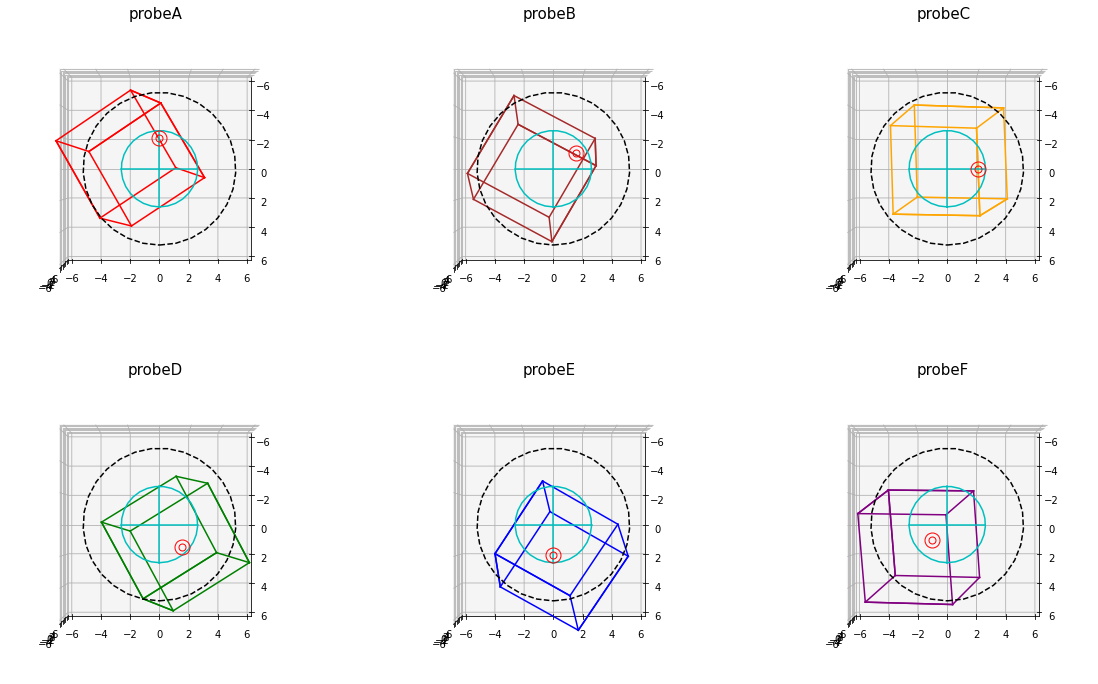

In [5]:
fig = plt.figure(figsize=(20,12))

def plot_circle(radius, style='--k'):
    angles = np.linspace(0,2*np.pi,30)
    xp = radius * np.cos(angles);
    yp = radius * np.sin(angles);
    zp = np.zeros(angles.size)
    plt.plot(xp,yp,zp,style)

   
corners = (np.array([[1,1,1],
                    [1,-1,1],
                    [-1,-1,1],
                    [-1,1,1],
                    [1,1,1],
                    [1,1,-1],
                    [1,-1,-1],
                    [-1,-1,-1],
                    [-1,1,-1],
                    [1,1,-1],
                    [1,1,-1],
                    [1,-1,-1],
                    [1,-1,1],
                    [-1,-1,1],
                    [-1,-1,-1],
                    [-1,-1,1],
                    [-1,1,1],
                    [-1,1,-1]]))*(manipulator_range / 2)

colors = ('red','brown','orange','green','blue','purple')

probe_idx = -1

for key, color in zip(results.keys(), colors):
    
    probe_idx += 1

    ax = fig.add_subplot(231 + probe_idx, projection='3d')

    invRotMat = np.linalg.inv(results[key]['rotation'])
    
    for c in range(corners.shape[0]-1):
        
        pt1 = corners[c,:].T
        pt2 = corners[c+1,:].T
        
        pt1a = np.dot(pt1, invRotMat) - results[key]['offset']
        pt2a = np.dot(pt2, invRotMat) - results[key]['offset']
    
        plt.plot([pt1a[0],pt2a[0]], [pt1a[1],pt2a[1]], [pt1a[2],pt2a[2]],color=color)
        
    ax.set_ylim([-6,6])
    ax.set_xlim([-6,6])
    ax.set_zlim([-6,6])
    
    plot_circle(5)
    plot_circle(2.5,'-c')
    plt.plot([-2.5,2.5],[0,0],'-c')
    plt.plot([0,0],[-2.5,2.5],'-c')
    plt.plot(np.array([targets[key][0]]),
             np.array([targets[key][1]]),
             np.array([targets[key][2]]),'or', markersize=7, markerfacecolor='none')
    plt.plot(np.array([targets[key][0]]),
             np.array([targets[key][1]]),
             np.array([targets[key][2]]),'or', markersize=15, markerfacecolor='none')
    
    plt.gca().invert_zaxis()
    ax.view_init(elev=90., azim=0.)
    
    plt.title(key, fontsize=15)